## Benchmark Model

- Training data made with some overlap
- feature set 3; ie with fft components

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from functools import reduce
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_error
from IPython.display import display
import gen_features
from multiprocessing import Process, Value
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('whitegrid')

fset = 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1) Extract dataset with features and target from csv files

In [19]:
# Read specified chunks of training data
if "feature_set{}.csv".format(fset) not in os.listdir("Features"):
    read_chunks = list(range(1,141))
    data_list = []
    folder = "temp"
    filename = 'text.txt'
    kwargs = {'gen_features' : gen_features.gen_features3,
              'overlap_ratio' : 0.5,
             }
    for k in tqdm_notebook(read_chunks):
        p = Process(target=gen_features.gen_dim_reduced_dataset,args=(k,),kwargs=kwargs)
        p.start()
        p.join()
        if k%20 == 0:
            with open(os.path.join(folder,filename),'r') as file:
                print(file.read())
    
    data_list = [pd.read_csv(os.path.join("temp","dim_reduced_train{}.csv".format(k))).iloc[:,1:] for k in read_chunks]
    data = pd.concat(data_list,axis=0,ignore_index=True)
    data.to_csv(os.path.join("Features","feature_set{}.csv".format(fset)))
else:
    print("Feature set {} already extracted.".format(fset))
    data = pd.read_csv(os.path.join("Features","feature_set{}.csv".format(fset))).iloc[:,1:]

Ppid: 8256
Pid: 17052
k= 20
segment_size = 150000
increment/segment_size = 0.500
Memory use = 60.7%

Ppid: 8256
Pid: 8428
k= 40
segment_size = 150000
increment/segment_size = 0.500
Memory use = 60.4%

Ppid: 8256
Pid: 5112
k= 60
segment_size = 150000
increment/segment_size = 0.500
Memory use = 60.4%

Ppid: 8256
Pid: 5752
k= 80
segment_size = 150000
increment/segment_size = 0.500
Memory use = 59.4%

Ppid: 8256
Pid: 8176
k= 100
segment_size = 150000
increment/segment_size = 0.500
Memory use = 58.5%

Ppid: 8256
Pid: 16192
k= 120
segment_size = 150000
increment/segment_size = 0.500
Memory use = 59.1%

Ppid: 8256
Pid: 12928
k= 140
segment_size = 150000
increment/segment_size = 0.500
Memory use = 58.7%



In [20]:
x_df = data.drop(['time_to_failure'],axis=1)
y_df = data['time_to_failure']

In [21]:
data.tail()

,mean,std,max,min,skew,kurtosis,"fft_[10000,60000]Hz","fft_[60000,120000]Hz","fft_[120000,160000]Hz","fft_[160000,200000]Hz","fft_[200000,230000]Hz","fft_[230000,300000]Hz",time_to_failure
8352,4.465257,4.160357,94,-97,0.029727,60.777211,3212.913841,6333.675412,6171.948466,12676.289921,7438.058586,18616.741545,9.809799
8353,4.527216,4.015878,94,-97,-0.006550,64.780261,2936.610816,5412.592759,7065.984208,8342.581962,8935.624199,18696.348481,9.790597
8354,4.518397,3.375543,64,-66,-0.123667,15.873745,3028.208144,4591.158573,5761.275028,7040.340858,6222.513712,10733.749928,9.771496
8355,4.479615,3.448699,64,-66,-0.139434,17.734203,2929.155886,4203.377846,4882.782374,6053.966456,6169.025649,11202.868166,9.759796
8356,4.565128,3.282740,46,-33,0.013554,6.720458,1832.837599,2066.084532,2648.121990,3697.423229,3152.102198,5740.628906,9.759796


#### 3) Explore the data (only basic comparisons, since this is only for the benchmark model)

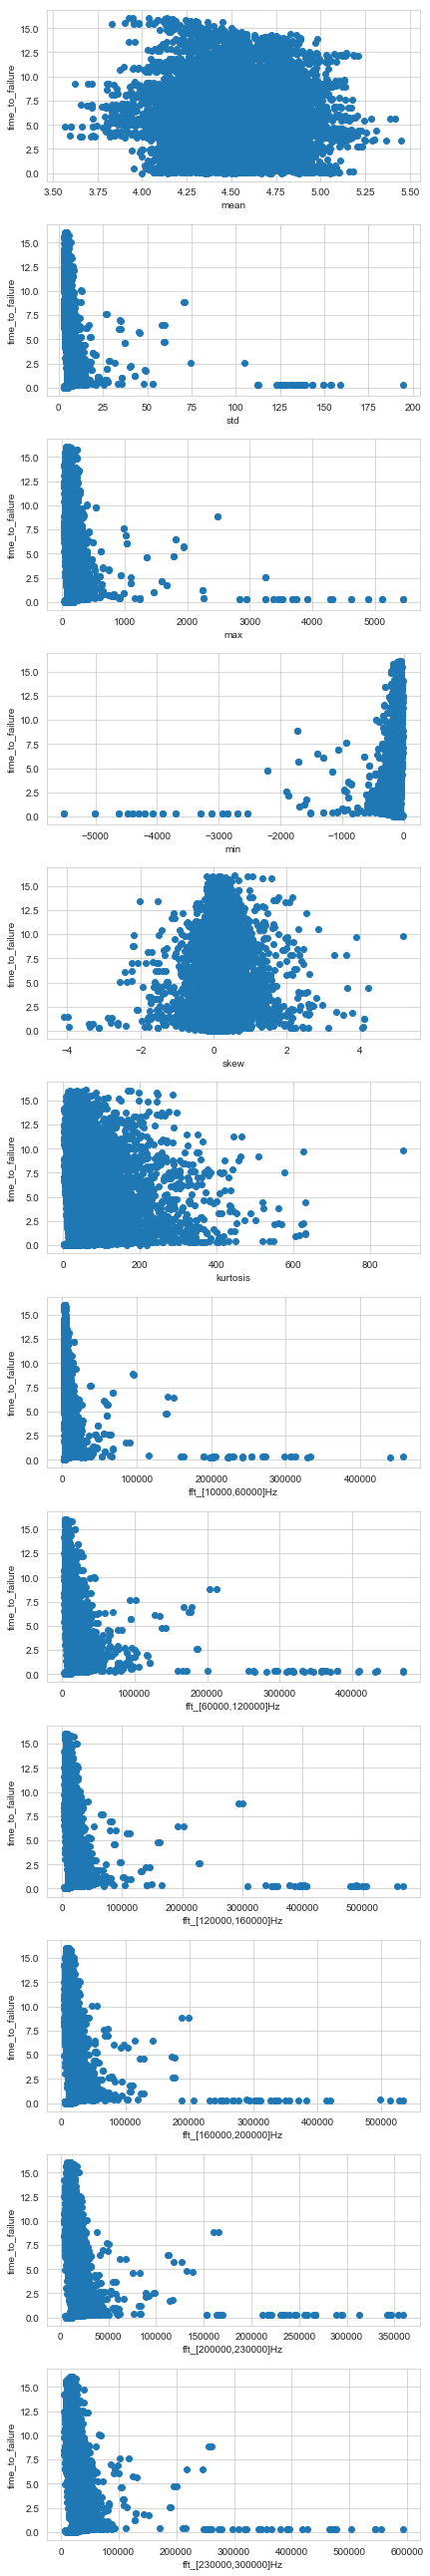

In [22]:
nrows = x_df.shape[1]
fig, axes = plt.subplots(nrows,figsize = (6,nrows*3))

for i,axis in enumerate(axes):
    axis.scatter(x_df.iloc[:,i],y_df)
    axis.set_xlabel(x_df.columns[i])
    axis.set_ylabel('time_to_failure')
plt.tight_layout()

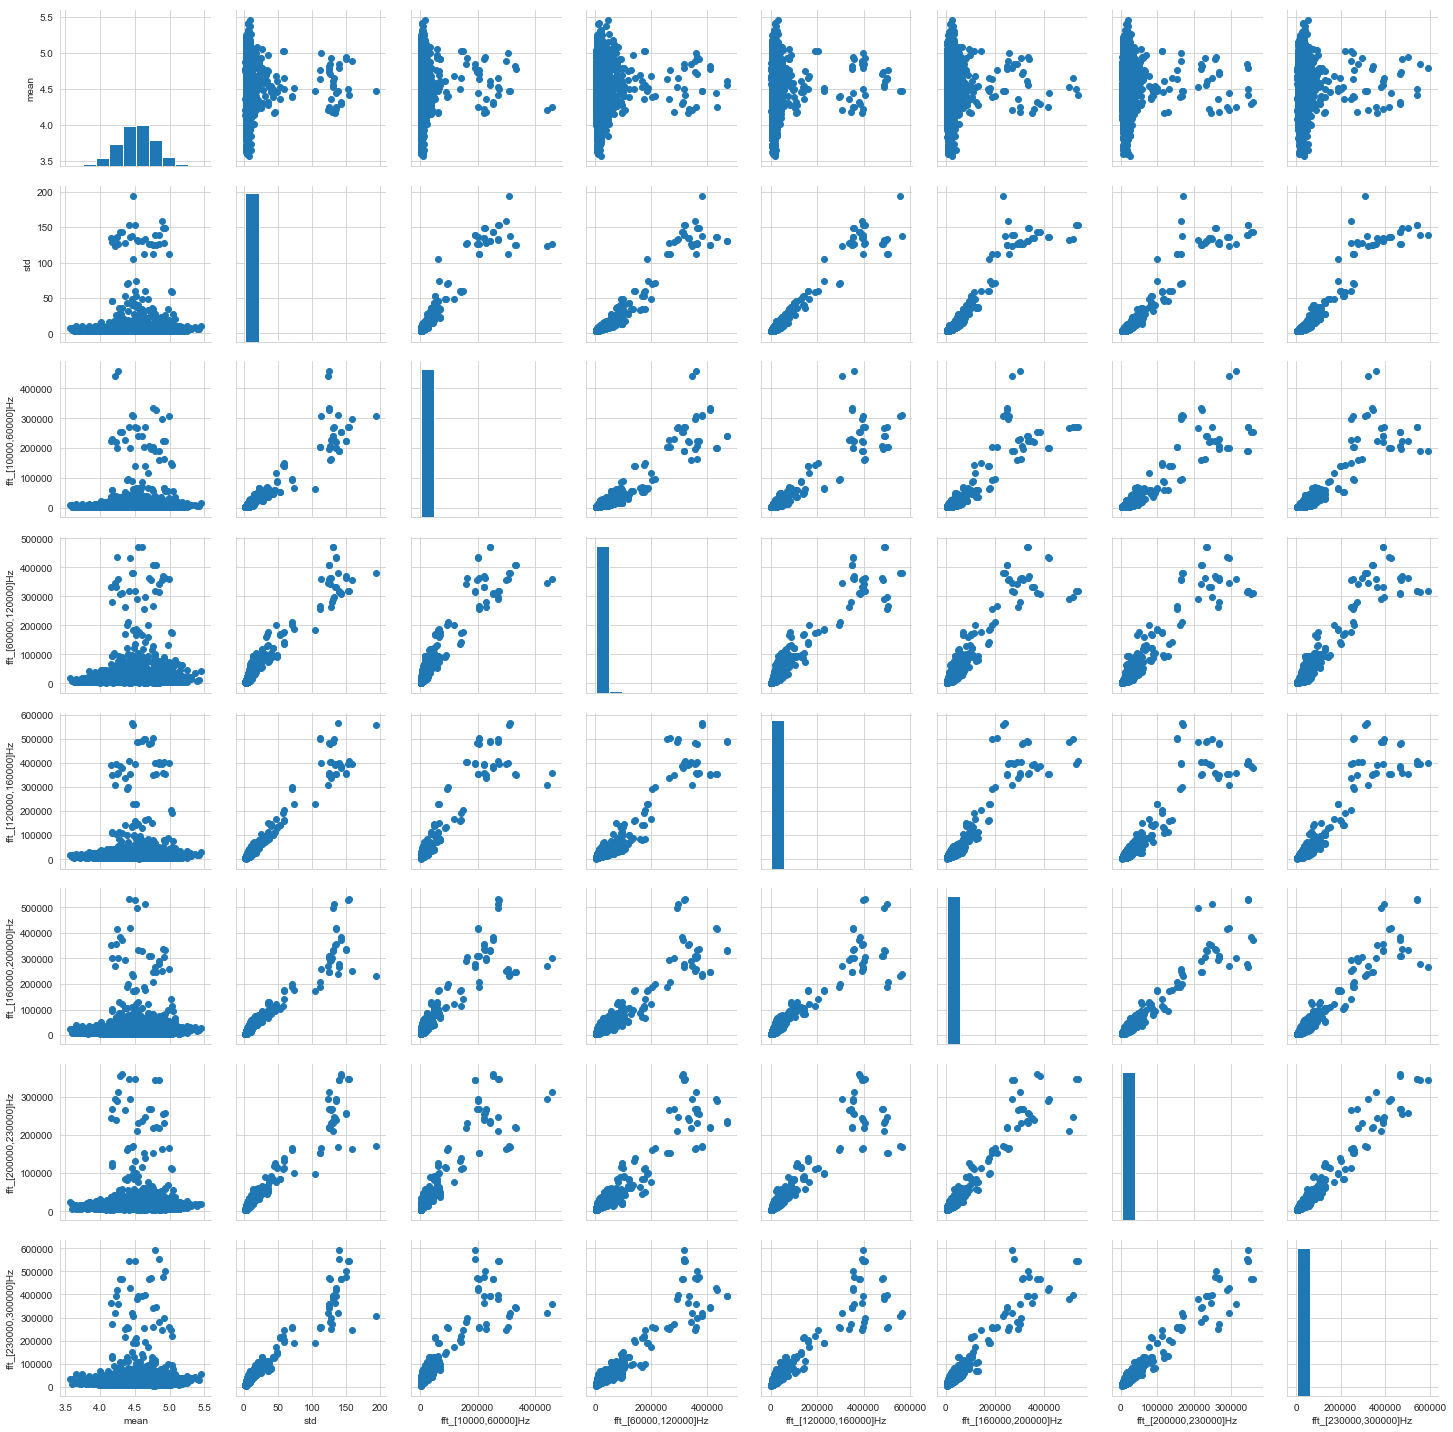

In [24]:
pair_plot = sns.PairGrid(x_df.iloc[:,[0,1,6,7,8,9,10,11]])
pair_plot = pair_plot.map_offdiag(plt.scatter)
pair_plot = pair_plot.map_diag(plt.hist)

#### 4) Split data into training and testing data

- Use 35% of data for testing

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df,y_df,test_size=0.35,random_state = 0)

#### 5) Set up an Initial model for Random Forest Regressor

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [27]:
regressor = RandomForestRegressor(n_estimators=10,max_depth = 3,criterion='mae')
res = cross_val_score(regressor,X_train,y_train.values.ravel(),
                      scoring='neg_mean_absolute_error',cv=5)
print('Mean CV score: {:.3f}, Std. Dev. of CV scores {:.3f}'.format(
    np.mean(res),np.std(res)))

Mean CV score: -2.253, Std. Dev. of CV scores 0.043


#### 6) Investigate quality of initial model

In [28]:
# Make a final benchmark model by training on the entire training data
from sklearn.base import clone
regressor_final = clone(regressor)
regressor_final = regressor_final.fit(X_train,y_train.values.ravel())

In [29]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    regressor_final,X_train,y_train.values.ravel(), cv=4,scoring='neg_mean_absolute_error')

Text(0.5, 1.0, 'Learning Curve for Benchmark Random Forest Regressor Model')

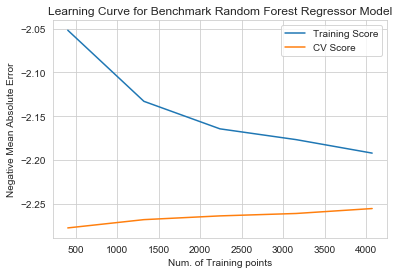

In [30]:
plt.plot(train_sizes,np.mean(train_scores,axis=1),label='Training Score')
plt.plot(train_sizes,np.mean(valid_scores,axis=1),label='CV Score')
plt.legend()
plt.xlabel('Num. of Training points')
plt.ylabel('Negative Mean Absolute Error')
plt.title('Learning Curve for Benchmark Random Forest Regressor Model')

In [33]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(
    regressor_final,X_train,y_train.values.ravel(),
    'n_estimators',[10,25,50,100], cv=5,scoring='neg_mean_absolute_error')

Text(0, 0.5, 'neg_mean_absolute_error ratio w.r.t mean')

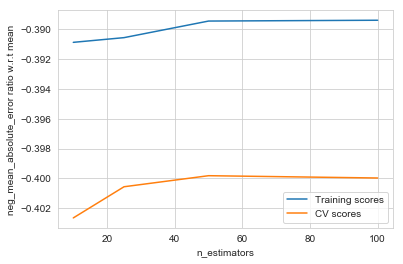

In [34]:
n_estimators = [10,25,50,100]
mean_y = y_train.values.mean()
plt.plot(n_estimators,np.mean(train_scores,axis=1)/mean_y,label='Training scores')
plt.plot(n_estimators,np.mean(valid_scores,axis=1)/mean_y,label='CV scores')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('neg_mean_absolute_error ratio w.r.t mean')

#### 7) Set up GridSearchCV to improve model by tuning hyperparameters

In [35]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [4,5,6,7,8],
          'min_samples_leaf' : [0.05,0.1,0.2],
          'n_estimators' : [40],
          }

grid = GridSearchCV(regressor_final,param_grid=params,scoring='neg_mean_absolute_error',
                   cv = 4)
grid.fit(X_train,y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [4, 5, 6, 7, 8], 'min_samples_leaf': [0.05, 0.1, 0.2], 'n_estimators': [40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [36]:
display(sorted(grid.cv_results_.keys()))
display(grid.cv_results_['mean_train_score'])
display(grid.cv_results_['mean_test_score'])

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_max_depth',
 'param_min_samples_leaf',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([-2.19379581, -2.26919102, -2.41968824, -2.19151944, -2.27171708,
       -2.42364435, -2.1918277 , -2.27630914, -2.41895824, -2.19130318,
       -2.27299256, -2.41733761, -2.19360972, -2.27587937, -2.41227121])

array([-2.25440675, -2.30772208, -2.44734605, -2.25108916, -2.31009908,
       -2.44521211, -2.25080266, -2.31627065, -2.44428799, -2.2518143 ,
       -2.31259332, -2.441962  , -2.25449406, -2.31340773, -2.43794366])

In [37]:
best_regr = grid.best_estimator_
best_regr

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.05, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Text(0.5, 1.0, 'Learning Curve for Benchmark Random Forest Regressor Model')

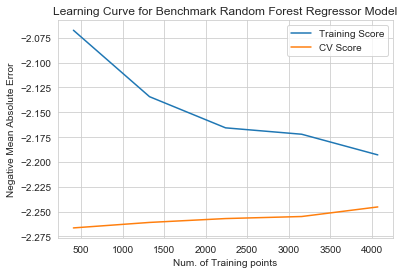

In [38]:
train_sizes, train_scores, valid_scores = learning_curve(
    best_regr,X_train,y_train.values.ravel(), cv=4,scoring='neg_mean_absolute_error')

plt.plot(train_sizes,np.mean(train_scores,axis=1),label='Training Score')
plt.plot(train_sizes,np.mean(valid_scores,axis=1),label='CV Score')
plt.legend()
plt.xlabel('Num. of Training points')
plt.ylabel('Negative Mean Absolute Error')
plt.title('Learning Curve for Benchmark Random Forest Regressor Model')

Text(0, 0.5, 'neg_mean_absolute_error ratio w.r.t mean')

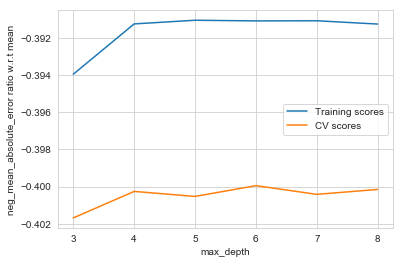

In [39]:
train_scores, valid_scores = validation_curve(
    best_regr,X_train,y_train.values.ravel(),
    'max_depth',[3,4,5,6,7,8], cv=5,scoring='neg_mean_absolute_error')

max_depth = [3,4,5,6,7,8]
mean_y = y_train.values.mean()
plt.plot(max_depth,np.mean(train_scores,axis=1)/mean_y,label='Training scores')
plt.plot(max_depth,np.mean(valid_scores,axis=1)/mean_y,label='CV scores')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('neg_mean_absolute_error ratio w.r.t mean')

Text(0, 0.5, 'neg_mean_absolute_error ratio w.r.t std')

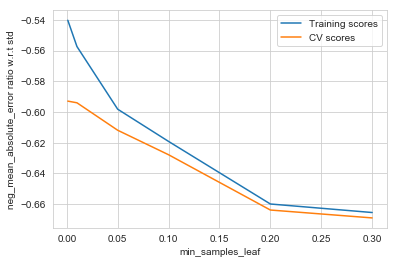

In [40]:
train_scores, valid_scores = validation_curve(
    best_regr,X_train,y_train.values.ravel(),
    'min_samples_leaf',[0.001,0.01,0.05,0.1,0.2,0.3], cv=5,scoring='neg_mean_absolute_error')

min_samples_leaf = [0.001,0.01,0.05,0.1,0.2,0.3]
mean_y = y_train.values.mean()
std_y = y_train.values.std()
plt.plot(min_samples_leaf,np.mean(train_scores,axis=1)/std_y,label='Training scores')
plt.plot(min_samples_leaf,np.mean(valid_scores,axis=1)/std_y,label='CV scores')
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('neg_mean_absolute_error ratio w.r.t std')

In [41]:
y_train_pred = best_regr.predict(X_train)
y_test_pred = best_regr.predict(X_test)

train_score = mean_absolute_error(y_train,y_train_pred)
test_score = mean_absolute_error(y_test,y_test_pred)

print(train_score)
print(test_score)

2.20444183302173
2.2581414826553234


In [42]:
for i,j in zip(X_train.columns,best_regr.feature_importances_):
    print("{} : {:.3f}".format(i,j))

mean : 0.000
std : 0.834
max : 0.000
min : 0.000
skew : 0.002
kurtosis : 0.098
fft_[10000,60000]Hz : 0.011
fft_[60000,120000]Hz : 0.003
fft_[120000,160000]Hz : 0.004
fft_[160000,200000]Hz : 0.001
fft_[200000,230000]Hz : 0.015
fft_[230000,300000]Hz : 0.032


In [43]:
benchmark_pred = pd.DataFrame(best_regr.predict(data.iloc[:,:-1]),index=data.index,columns = ['Benchmark Prediction'])

Text(0.5, 0, 'Sample #')

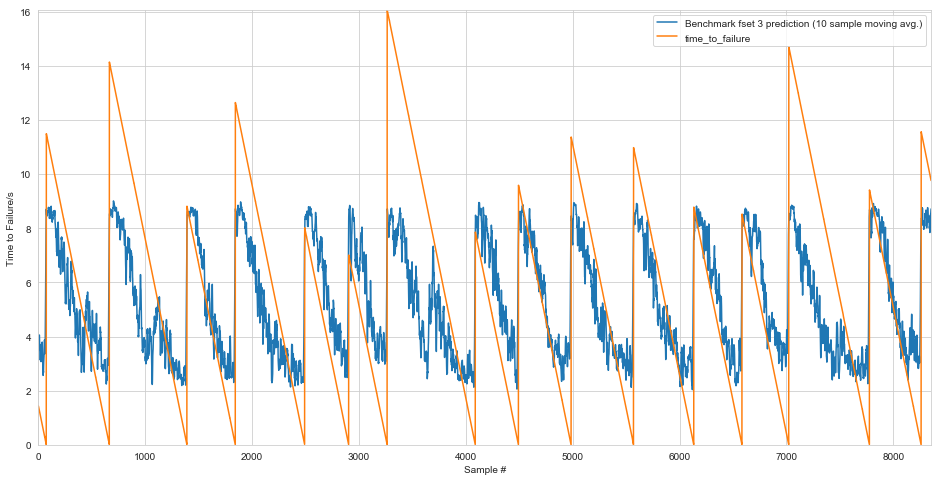

In [45]:
xdata = data.iloc[:,:-1]
normalized_xdata = (xdata-xdata.min())/(xdata.max()-xdata.min())
fig,axis = plt.subplots(figsize=(16,8))
window = 10
axis.plot(benchmark_pred.rolling(window).mean(),
          label="Benchmark fset 3 prediction ({} sample moving avg.)".format(window))
axis.plot(data['time_to_failure'])
plt.legend()
plt.xlim((data.index[0],data.index[-1]))
plt.ylim((0,data['time_to_failure'].max()))
plt.ylabel('Time to Failure/s')
plt.xlabel('Sample #')

Similar to the paper, the stndard deviation is found to be the most useful parameter in predicting the time remaining until the next earthquake.

In [ ]:
best_regr.class_weight